# **CFAR Part 3**

In this notebook, we will expand on part 2 and attempt to detect targets directly via CFAR instead of projecting them to a Point Cloud. We will do this by creating a dynamic threshold that will allow us to suppress low RCS targets and focus on high RCS targets of interest. Let's get started.

### TI refs:

- https://www.ti.com/lit/an/swra621/swra621.pdf
- https://www.ti.com/lit/ug/swru526b/swru526b.pdf?ts=1715458835223


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from utils.radar_params import *
from radar.range_processing import *
from radar.doppler_processing import *
from radar.azimuth_processing import *
from radar.cfar import *

%matplotlib inline

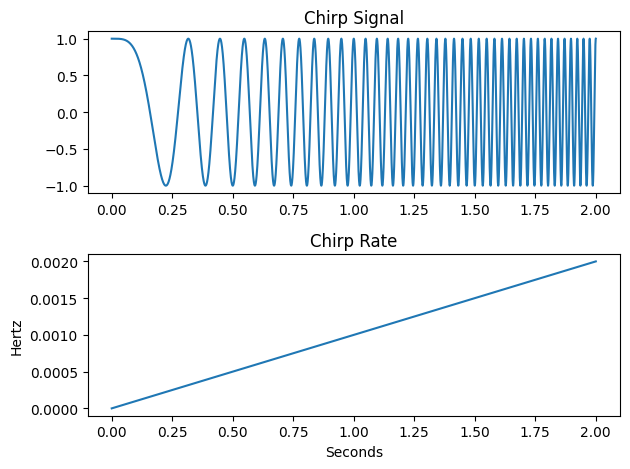

In [2]:
Tc = 2 # chirp duration (seconds)
fs = 10000 # sample frequency (Hz)
t = np.linspace(0, Tc, fs) # time domain samples

S = 10 # chirp slope (Hz / s)

x = np.cos(2*np.pi*t**2 * S)

_, ax = plt.subplots(2, 1)
ax[0].plot(t, x);
ax[0].set_title("Chirp Signal");
ax[1].plot(t, t*S/fs)
ax[1].set_title("Chirp Rate")
ax[1].set_ylabel("Hertz")
ax[1].set_xlabel("Seconds");

plt.tight_layout();

## Helper functions

In [3]:
# def get_nhood(arr, x, y, nsize=2):
#     return arr[y-nsize:y+nsize+1, x-nsize:x+nsize+1]


# def cfar_nms(cfar_peaks, signal_arr, nsize=2):
#     """ Performs non-maximal supprression on detected CFAR peaks """
#     nms_peaks = np.zeros(cfar_peaks.shape)
#     for y, x in zip(*np.where(cfar_peaks == 1)):
#         if np.all(signal_arr[y, x] >= get_nhood(signal_arr, x, y, nsize)):
#             nms_peaks[y, x] = 1

#     return nms_peaks


def get_nhood(arr, x, y, axis=None, nsize=2):
    
    if not axis:
        hood = arr[y-nsize:y+nsize+1, x-nsize:x+nsize+1]
    elif axis == 0:
        hood = arr[y-nsize:y+nsize+1, x]
    elif axis == 1:
        hood = arr[y, x-nsize:x+nsize+1]

    return hood

def cfar_nms_single_ax(cfar_peaks, signal_arr, axis=None, nsize=2):
    """ Performs non-maximal supprression on detected CFAR peaks """
    nms_peaks = np.zeros(cfar_peaks.shape)
    for y, x in zip(*np.where(cfar_peaks == 1)):
        if np.all(signal_arr[y, x] >= get_nhood(signal_arr, x, y, axis, nsize)):
            nms_peaks[y, x] = 1

    return nms_peaks

def cfar_nms(cfar_peaks, signal_arr, nsize=2):
    """ Performs non-maximal supprression on detected CFAR peaks """
    nms_peaks = np.zeros(cfar_peaks.shape)
    for y, x in zip(*np.where(cfar_peaks == 1)):
        if np.all(signal_arr[y, x] >= get_nhood(signal_arr, x, y, None, nsize)):
            nms_peaks[y, x] = 1

    return nms_peaks

### Get Data

In [4]:
DATA_PATH = "../indoor_sample_50.h5"
CONFIG_PATH = "/home/iberrios/Documents/datasets/radical/data/radarcfg/indoor_human_rcs.cfg"

In [5]:
import h5py

data_dict = {}
with h5py.File(DATA_PATH, 'r') as h5_obj:
    for key in h5_obj.keys():
        data_dict.update({key : np.asarray(h5_obj[key])})

In [6]:
data_idx = 29
adc_data = data_dict['radar'][data_idx, ...]

### Get Range and Doppler bin values

In [7]:
with open(CONFIG_PATH, 'r') as f:
    for line in f.readlines():
        if 'profileCfg' in line:
            line = line.split(' ')

            start_freq = float(line[2]) # GHz
            idle_time = float(line[3]) # usec
            ramp_end_time = float(line[5]) # usec
            chirp_slope = float(line[8]) # MHz/usec
            num_adc_samples = float(line[10]) # unitless
            adc_sample_rate = float(line[11]) # Msps

        elif 'channelCfg' in line:
            line = line.split(' ')

            # number of receive antennas
            rx_bin = bin(int(line[1])).zfill(4)
            num_rx = len([i for i in rx_bin if i == '1'])

            # number of transmit antennas
            tx_bin = bin(int(line[2])).zfill(4)
            num_tx = len([i for i in tx_bin if i == '1'])

### Prcoess Data

In [8]:
range_resolution, bandwidth = compute_range_resolution(adc_sample_rate, num_adc_samples, chirp_slope)
max_range = range_resolution * num_adc_samples

num_chirps = adc_data.shape[0]
chirp_interval = (ramp_end_time + idle_time) * 1e-6 # usec

doppler_resolution = compute_doppler_resolution(num_chirps, bandwidth, chirp_interval, num_tx)
max_doppler = doppler_resolution * num_chirps / 2

In [9]:
# perform Fast Time Range FFT
range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0).astype(np.complex64)

# perform Slow Time Doppler FFT
range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2).astype(np.complex64)

# perform azimuth processing
steering_vector = compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90)
range_azimuth = capon_spectrum(range_doppler, steering_vector)

### Get Range Doppler Matrix

To get the 2D Range-Doppler matrix, we first sum across receive antennas and then take magnitude of the complex values. This operation reduces the size of the Range-Doppler data by a factor of 16 (8 from summing across the antennas and 2 for computing the magnitude of the complex data), see below. After we take the magnitude, we can either square it or take the base 2 logarithm in accordance with the Texas Instruments Radar Processing pipeline.

##### NOTE:
In reality, we would implement this on real Radar Hardware (H/W) i.e. a TI mmWave Radar sensor or similar. The TI mmmWave Radar H/W accelerator makes approximations which will introduce some (presumably acceptable) errors in the processing with the benefit of increased speed. Some main approximations for this step are listed below, knowing and understanding them will by helpful if you decide to implement this Radar processing on real H/W.

- [Look Up Table (LUT) log2 computation](https://www.mathworks.com/help/fixedpoint/ug/implement-fixed-point-log2-using-lookup-table.html)
- [JPL Approximation for magnitude of IQ data](https://ipnpr.jpl.nasa.gov/progress_report2/42-40/40L.PDF)
- Approximate "Averaging"
    - Sum all numbers and divide by a power of 2 (i.e. $2^n$)
    - Since this approximation might be far off, additional scaling factors may be used

Also, in the TI H/W CFAR implementation, an arbitrary scale factor or additive constant is utilized to generate the dynamic threshold. This is different from the more 'theoretical' approach we are currently using.

##### NOTE:
Different ways of processing the Range Doppler matrix, i.e. square magnitude, log, etc,... will lead to different CFAR results due to scaling.

In [14]:
range_doppler_mat = np.log2(np.abs(range_doppler.sum(axis=1))) # log magnitude
# range_doppler_mat = np.abs(range_doppler.sum(axis=1))**2 # magnitude squared

Reduction factor after computing the range doppler matrix

In [15]:
(range_doppler.size*64) / (range_doppler_mat.size*32)

16.0

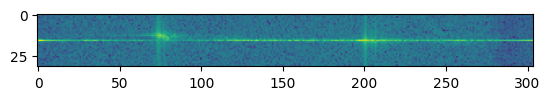

In [16]:
plt.imshow(range_doppler_mat.T);

### Perform CFAR Detection along Doppler rows

In this notebook, we will opt to adjust the dynamic threshold level with either a scale factor or an additive constant. We will use the scale factor for square magnitude values, and the constant for logarithmic values.

In [17]:
# cfar in Doppler direction 
noise_level_dop, _= np.apply_along_axis(ca_cfar, 
                                        axis=0, 
                                        arr=range_doppler_mat.T,
                                        prob_fa=0.05, 
                                        num_train=8, 
                                        num_gaurd=3)
# set doppler scale factor
doppler_thresh = 4

# threshold detections and perform NMS
doppler_peaks = range_doppler_mat > (noise_level_dop.T + doppler_thresh)
# doppler_peaks = cfar_nms_single_ax(doppler_peaks, range_doppler_mat, axis=1, nsize=1)


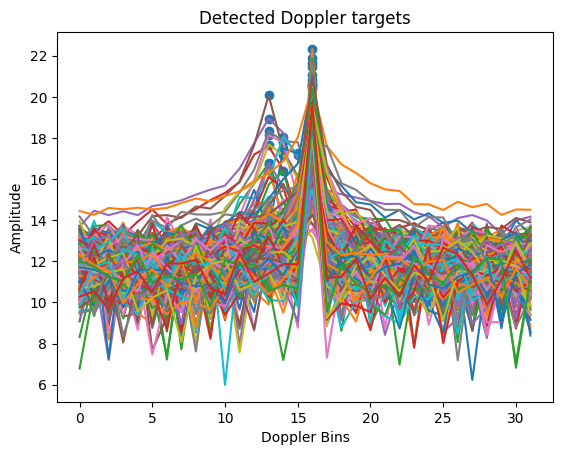

In [20]:
plt.plot(range_doppler_mat.T);
plt.scatter(np.where(doppler_peaks)[1], 
            range_doppler_mat[np.where(doppler_peaks)]);

plt.title("Detected Doppler targets");
plt.xlabel("Doppler Bins")
plt.ylabel("Amplitude");

### Perform CFAR Detection across Range Bins

Now we will perform CFAR detection, across range bins. Normally, we would only perform this on range bins with a Doppler hit, but we will work around this in Python by zeroing detections that 

In [21]:
# cfar in range direction 
noise_level_rng, _ = np.apply_along_axis(ca_cfar, 
                                         axis=0, 
                                         arr=range_doppler_mat,
                                         prob_fa=0.1, 
                                         num_train=32, 
                                         num_gaurd=8)

range_thresh = 3

range_peaks = range_doppler_mat > (noise_level_rng + range_thresh)
# range_peaks = cfar_nms_single_ax(range_peaks, range_doppler_mat, axis=0, nsize=1)

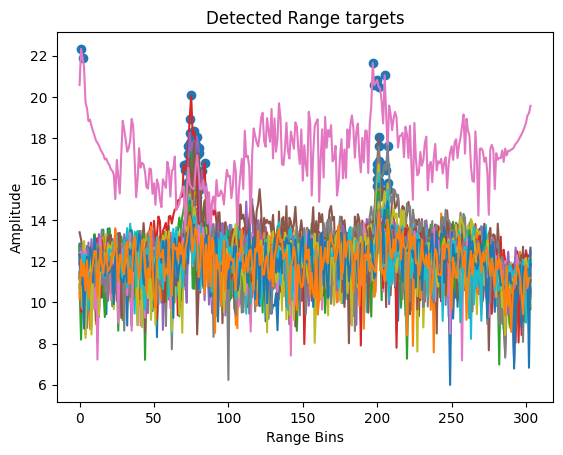

In [23]:
plt.plot(range_doppler_mat);
plt.scatter(np.where(range_peaks)[0], 
            range_doppler_mat[np.where(range_peaks)]);

plt.title("Detected Range targets");
plt.xlabel("Range Bins");
plt.ylabel("Amplitude");

In [276]:
# plt.plot(range_doppler_mat[:, 16], color='m');
# plt.scatter(np.where(range_peaks[:, 16])[0], 
#             range_doppler_mat[:, 16][np.where(range_peaks[:, 16])]);

In [25]:
peaks = range_peaks.astype(bool) & doppler_peaks.astype(bool)
nms_peaks = cfar_nms(peaks, range_doppler_mat, nsize=1)

In [26]:
# plt.imshow(doppler_peaks.T)
# plt.imshow(range_peaks.T)

In [27]:
ranges = np.arange(0, max_range + range_resolution, range_resolution)
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

range_ticks = np.arange(0, len(ranges), len(ranges)//10)
range_tick_labels = ranges[::len(ranges)//10].round(2)

doppler_ticks = np.arange(0, len(dopplers), len(dopplers)//10)
doppler_tick_labels = dopplers[::len(dopplers)//10][::-1].round(2)

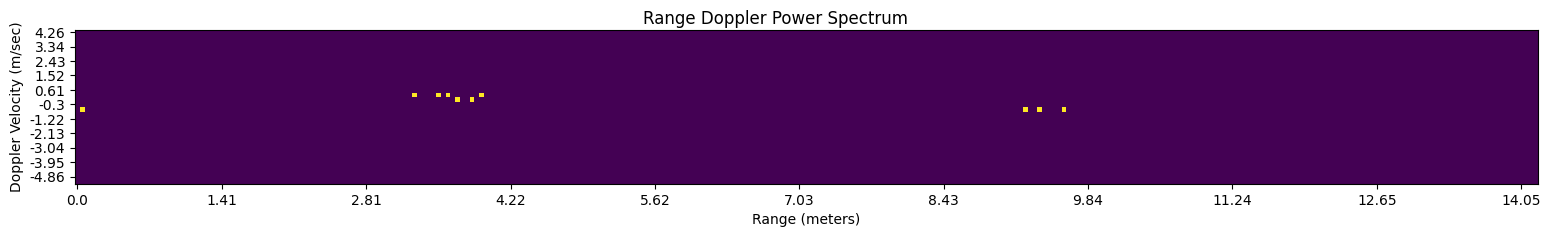

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(25, 2))
ax.imshow(nms_peaks.T)
fig.suptitle("Range Doppler Power Spectrum")
ax.set_xlabel("Range (meters)")
ax.set_ylabel("Doppler Velocity (m/sec)");

# apply Range and Doppler labels
ax.set_xticks(range_ticks, range_tick_labels);

ax.set_yticks(doppler_ticks, doppler_tick_labels);

In [30]:
nms_peaks.sum()

10.0

Let's recap, we have detections in terms of Range and Doppler Velocity.

In [31]:
range_bins, doppler_bins = np.where(nms_peaks)

range_bins, doppler_bins

(array([  1,  70,  75,  77,  79,  82,  84, 197, 200, 205]),
 array([16, 13, 13, 13, 14, 14, 13, 16, 16, 16]))

In [32]:
ranges = range_bins*range_resolution
dopplers = (16 - doppler_bins)*doppler_resolution

ranges, dopplers

(array([0.04683764, 3.27863485, 3.51282306, 3.60649834, 3.70017362,
        3.84068654, 3.93436182, 9.22701523, 9.36752815, 9.60171636]),
 array([0.        , 0.91218397, 0.91218397, 0.91218397, 0.60812265,
        0.60812265, 0.91218397, 0.        , 0.        , 0.        ]))

In [37]:
# number of possible angles
n_angles = steering_vector.shape[0]

# range bin indices where a target resides
range_bins = np.unique(np.where(nms_peaks)[0])

range_azimuth_mat = np.zeros((len(range_bins), n_angles), dtype=np.complex64)

for i, rng_bin in enumerate(range_bins):
    range_azimuth_mat[i,:] = aoa_capon(range_doppler[rng_bin, ...], steering_vector)

range_azimuth_mat = np.fliplr(range_azimuth_mat)

In [38]:
range_azimuth_mat.shape

(10, 181)

In [39]:
range_azimuth_mat = np.log2(np.abs(range_azimuth_mat))

Perform final detection to resolve across angle

In [40]:
# cfar in azimuth direction
noise_level_az, _ = np.apply_along_axis(ca_cfar, 
                                        axis=0, 
                                        arr=range_azimuth_mat.T,
                                        prob_fa=0.05, 
                                        num_train=14, 
                                        num_gaurd=2)

# set scale factor
az_thresh = 1.5

azimuth_peaks = range_azimuth_mat > (noise_level_az.T + az_thresh)
azimuth_peaks = cfar_nms_single_ax(azimuth_peaks, range_azimuth_mat, axis=1, nsize=1)

Number of Detected targets

In [41]:
azimuth_peaks.sum()

13.0

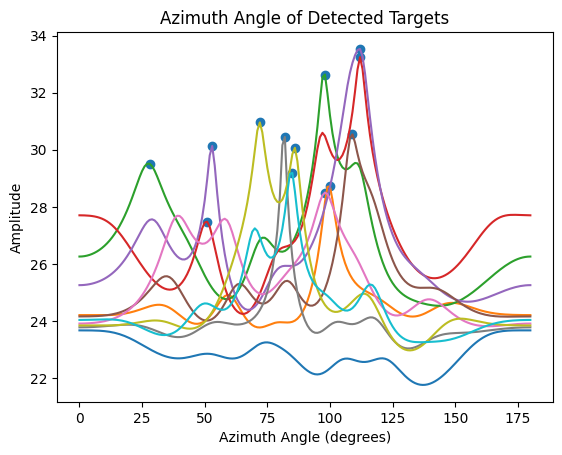

In [43]:
plt.plot(range_azimuth_mat.T);
plt.scatter(np.where(azimuth_peaks)[1], range_azimuth_mat[np.where(azimuth_peaks)]);

plt.title("Azimuth Angle of Detected Targets")
plt.xlabel("Azimuth Angle (degrees)")
plt.ylabel("Amplitude");

Now let's get the angle of our detected targets, in this case the angle bins are exactly the same as the degrees

In [45]:
range_idx, angles = np.where(azimuth_peaks)

for (r, d, a) in zip(ranges[range_idx], dopplers[range_idx], angles):
    print(f"Range: {r:0.2f} m, Doppler: {d:0.2f} m/s, Azimuth: {a} deg")

Range: 3.28 m, Doppler: 0.91 m/s, Azimuth: 100 deg
Range: 3.51 m, Doppler: 0.91 m/s, Azimuth: 28 deg
Range: 3.51 m, Doppler: 0.91 m/s, Azimuth: 98 deg
Range: 3.61 m, Doppler: 0.91 m/s, Azimuth: 51 deg
Range: 3.61 m, Doppler: 0.91 m/s, Azimuth: 112 deg
Range: 3.70 m, Doppler: 0.61 m/s, Azimuth: 53 deg
Range: 3.70 m, Doppler: 0.61 m/s, Azimuth: 112 deg
Range: 3.84 m, Doppler: 0.61 m/s, Azimuth: 109 deg
Range: 3.93 m, Doppler: 0.91 m/s, Azimuth: 98 deg
Range: 9.23 m, Doppler: 0.00 m/s, Azimuth: 82 deg
Range: 9.37 m, Doppler: 0.00 m/s, Azimuth: 72 deg
Range: 9.37 m, Doppler: 0.00 m/s, Azimuth: 86 deg
Range: 9.60 m, Doppler: 0.00 m/s, Azimuth: 85 deg


## Make a Pipeline

In this part, we are just aggregating the steps so that we can visualize the performance. There is no ground truth data so we can't really quantify how well things are working.

In [47]:
import cv2

# compute constants
steering_vector = compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90)
angle_vector = np.arange(-90, 91, 1)

# set scale factors
doppler_thresh = 4
range_thresh = 3
az_thresh = 1.5

In [48]:
adc_data.shape

(32, 8, 304)

In [49]:
frames = []

for i in range(len(data_dict['radar'])):

    ################################################################################
    ## get raw ADC data
    adc_data = data_dict['radar'][i, ...]

    # perform Fast Time Range FFT
    range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)

    # perform Slow Time Doppler FFT
    range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

    # perform azimuth processing and compute PSD for display purposes
    range_azimuth = capon_spectrum(range_doppler, steering_vector)
    range_azimuth_psd = np.abs(range_azimuth)**2

    ################################################################################
    ## perform CFAR detection across Doppler on log-mag of Range Azimuth matrix
    range_doppler_mat = np.log2(np.abs(range_doppler.sum(axis=1))) 

    # cfar in Doppler direction 
    noise_level_dop, _= np.apply_along_axis(ca_cfar, 
                                            axis=0, 
                                            arr=range_doppler_mat.T,
                                            prob_fa=0.05, 
                                            num_train=8, 
                                            num_gaurd=3)
    
    # threshold detections and perform NMS
    doppler_peaks = range_doppler_mat > (noise_level_dop.T + doppler_thresh)
    # doppler_peaks = cfar_nms_single_ax(doppler_peaks, range_doppler_mat, axis=1, nsize=1)    

    ################################################################################
    ## perform CFAR detection across Range on log-mag of Range Azimuth matrix

   # cfar in range direction 
    noise_level_rng, _ = np.apply_along_axis(ca_cfar, 
                                            axis=0, 
                                            arr=range_doppler_mat,
                                            prob_fa=0.1, 
                                            num_train=32, 
                                            num_gaurd=8)

    range_peaks = range_doppler_mat > (noise_level_rng + range_thresh)
    # range_peaks = cfar_nms_single_ax(range_peaks, range_doppler_mat, axis=1, nsize=1)

    ################################################################################
    ## Get Range Doppler Detections
    peaks = range_peaks & doppler_peaks
    peaks = cfar_nms(peaks, range_doppler_mat, nsize=1)

    if nms_peaks.sum() > 0:
        
        # get range and Doppler bins
        range_bins, doppler_bins = np.where(peaks)

        ################################################################################
        ## Resolve Targets in Azimuth
        
        # number of possible angles
        n_angles = steering_vector.shape[0]

        # range bin indices where a target resides
        unique_range_bins = np.unique(range_bins)
        range_azimuth_mat = np.zeros((len(range_bins), n_angles), dtype=np.complex64)

        # get Range Azimuth Matrix
        for j, rng_bin in enumerate(unique_range_bins):
            range_azimuth_mat[j, :] = aoa_capon(range_doppler[rng_bin, ...], steering_vector)
        
        range_azimuth_mat = np.fliplr(range_azimuth_mat)
        range_azimuth_mat = np.log2(np.abs(range_azimuth_mat))

        # cfar in azimuth direction
        noise_level_az, _ = np.apply_along_axis(ca_cfar, 
                                                axis=0, 
                                                arr=range_azimuth_mat.T,
                                                prob_fa=0.05, 
                                                num_train=14, 
                                                num_gaurd=2)
        
        azimuth_peaks = range_azimuth_mat > (noise_level_az.T + az_thresh)
        azimuth_peaks = cfar_nms_single_ax(azimuth_peaks, range_azimuth_mat, axis=1, nsize=1)
            
        ################################################################################
        ## Get Estimated Paramters
        range_idx, angles = np.where(azimuth_peaks)

        ranges = range_bins*range_resolution
        dopplers = (16 - doppler_bins)*doppler_resolution

        detections = np.zeros((len(range_idx), 3), dtype=np.float32)

        for j, (r, d, a) in enumerate(zip(ranges[range_idx], dopplers[range_idx], angles)):
            detections[j, ...] = np.array([r, d, a])
    
    else:
        detections = np.zeros((0, 0))

    ################################################################################
    ## draw detections on Range Az PSD
    
    # convert to normalized uint8 to save with opencv video writer
    range_az_img = cv2.normalize(np.log(range_azimuth_psd), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    range_az_img = range_az_img[:, :, None].repeat(3, axis=2)

    for rng, dop, az in detections:
        rng = int(num_adc_samples - rng/range_resolution)
        az = int(az)

        if dop == 0.0:
            cv2.circle(range_az_img, (az, rng), radius=1, color=(0,255,0), thickness=-1)
        else:
            cv2.circle(range_az_img, (az, rng), radius=1, color=(255,0,255), thickness=-1)


    ################################################################################
    # obtain rgb image and resize
    rgb = data_dict['rgb'][i, ...]
    ih, iw = rgb.shape[:2]
    iw2, ih2 = int(iw/2.361), int(ih/2.361)

    rgb = cv2.resize(rgb, (iw2, ih2))
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    zero_pad = np.zeros((ih2, 2, 3), dtype=np.uint8)

    frame = np.hstack((rgb, zero_pad, range_az_img))

    # append frame to list
    frames.append(frame)


#### Display Results

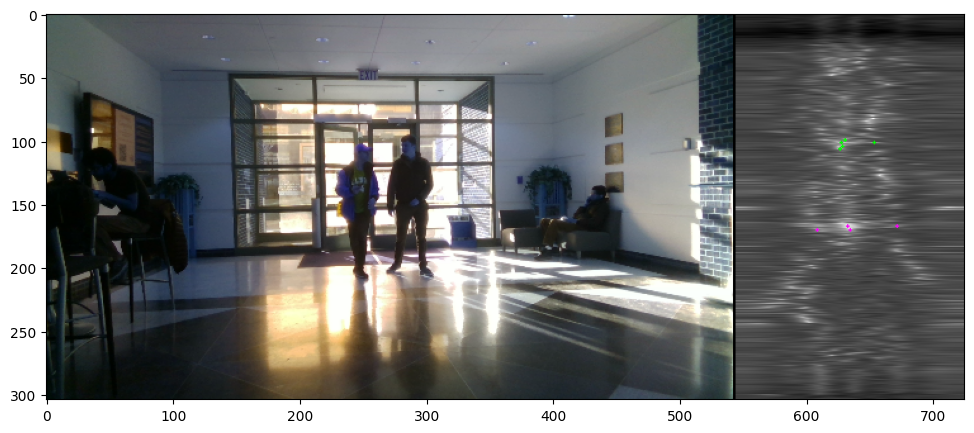

In [53]:
plt.figure(figsize=(15, 5))
plt.imshow(frames[25]);

### Make a Video

In [344]:
h, w = frame.shape[:2]

out = cv2.VideoWriter("../videos/range_azimuth_cfar_2_w_nms.avi",
                      cv2.VideoWriter_fourcc(*'DIVX'), # *'mp4v' *'MJPG' *'h264' *'x264' *'DIVX'
                      3,
                      (w, h))

for frame in frames:
    out.write(frame)

out.release()
del out